# OSG Statistics by Elevation
i.e. How does the p95 wind change with elevation throughout the year

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from collections import OrderedDict

import sys
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_data.grid_manager import pluck_point_new

from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b\n%d')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 8]
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.05
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.dpi'] = 100

In [72]:
# Create Map object for test plotting
m = draw_CONUS_HRRR_map()

# Load HRRR Lat/Lon/Elevation data
H = get_hrrr_variable(datetime(2017, 1, 1), variable='HGT:surface')
lat = H['lat']
lon = H['lon']

./temp_2017010100_f00_HGT.grib2
Oh, good, you requested a date that should be on Pando.
matched a variable 46:30408372:d=2017010100:HGT:surface:anl

range: 30408372 32644720


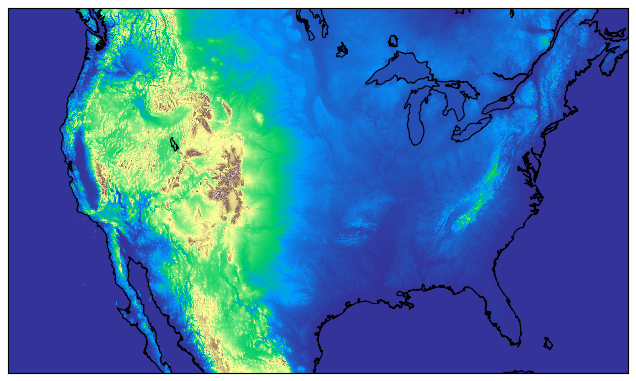

In [14]:
m.drawcoastlines()
m.pcolormesh(H['lon'], H['lat'], H['value'],
             cmap='terrain',
             vmin=0,
             latlon=True)

Create bins for the data

In [192]:
HGT_bins = np.arange(0, H['value'].max(), 100)
HGT_bins = np.append(HGT_bins, H['value'].max())
HGT_bins = np.append(H['value'].min(), HGT_bins)
HGT_bins[1] = 0.100

In [187]:
HGT_bins

array([  -74.94224548,     0.        ,   100.        ,   200.        ,
         300.        ,   400.        ,   500.        ,   600.        ,
         700.        ,   800.        ,   900.        ,  1000.        ,
        1100.        ,  1200.        ,  1300.        ,  1400.        ,
        1500.        ,  1600.        ,  1700.        ,  1800.        ,
        1900.        ,  2000.        ,  2100.        ,  2200.        ,
        2300.        ,  2400.        ,  2500.        ,  2600.        ,
        2700.        ,  2800.        ,  2900.        ,  3000.        ,
        3100.        ,  3200.        ,  3300.        ,  3400.        ,
        3500.        ,  3600.        ,  3700.        ,  3800.        ,
        3900.        ,  4000.        ,  4100.        ,  4183.77636719])

In [188]:
storage_p50 = np.zeros([len(HGT_bins), 12])
storage_p95 = np.zeros([len(HGT_bins), 12])
storage_mean = np.zeros([len(HGT_bins), 12])
storage_samples = np.zeros([len(HGT_bins), 12])
print np.shape(storage)

(11, 12)


Load the percentile data

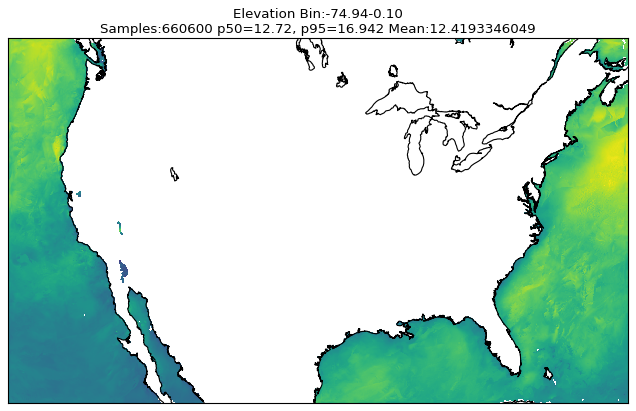

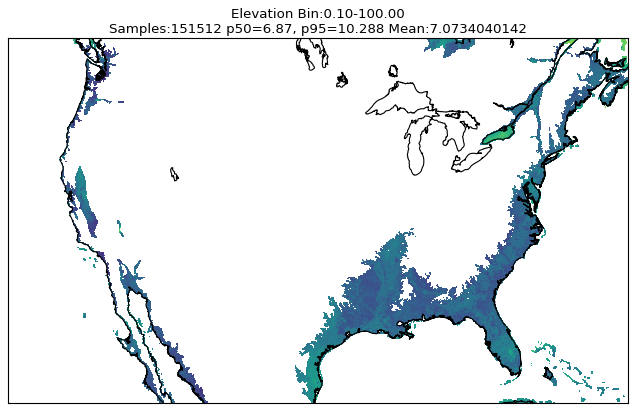

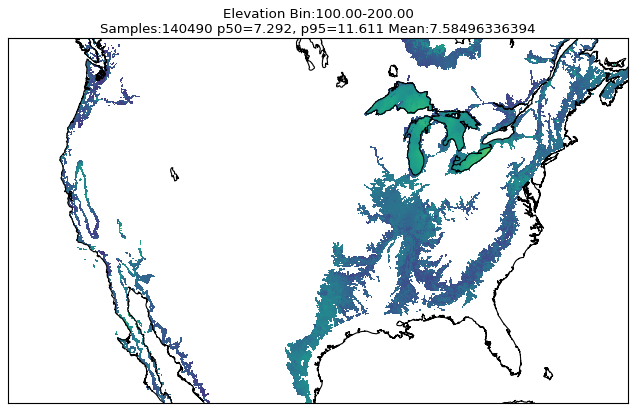

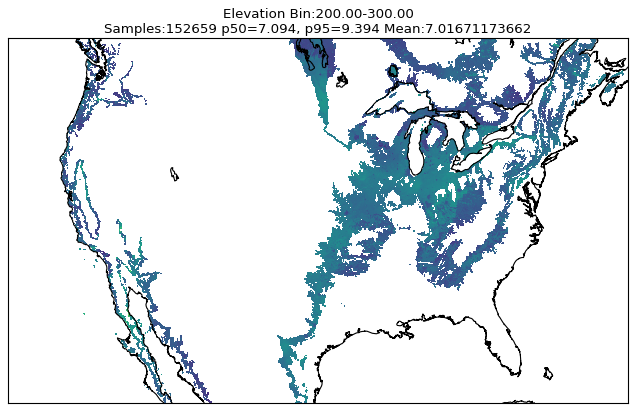

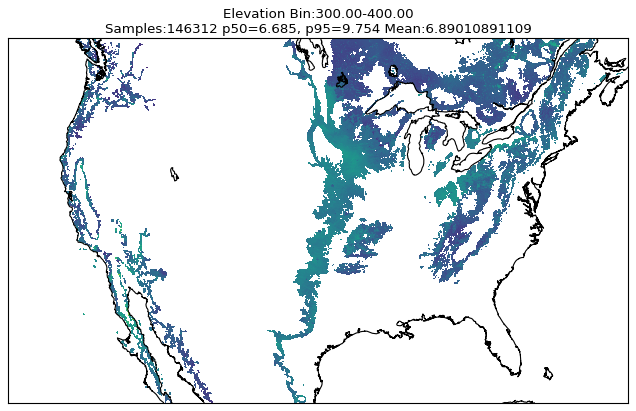

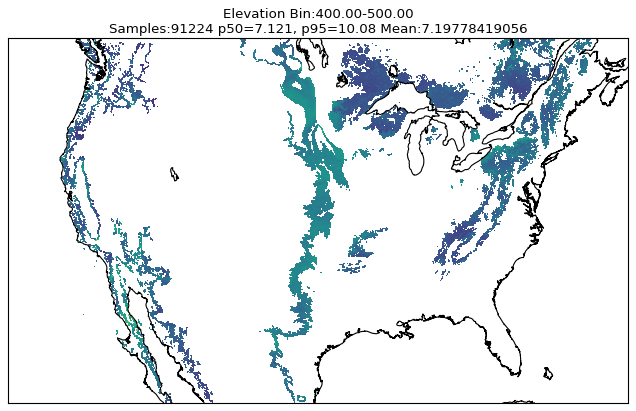

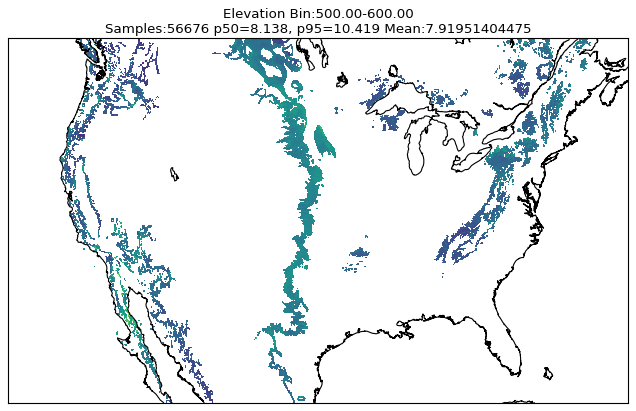

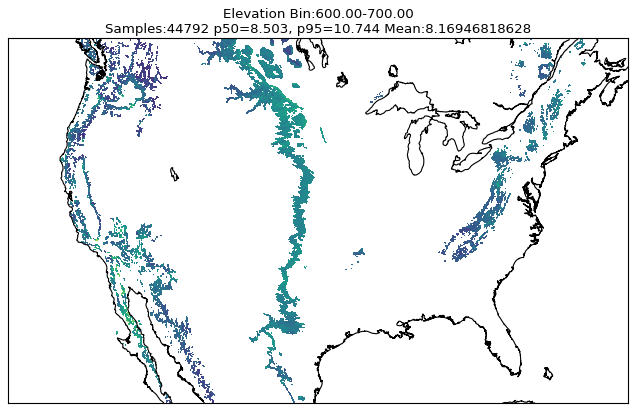

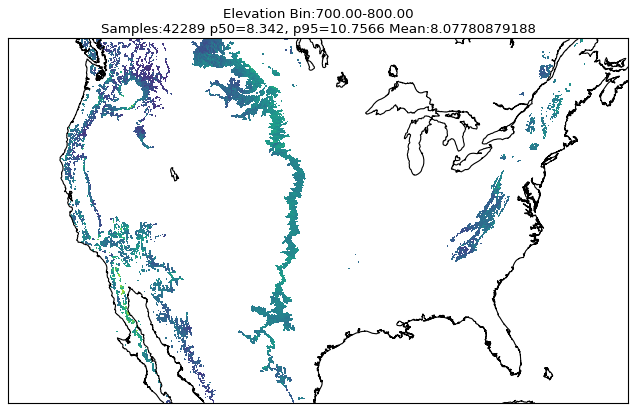

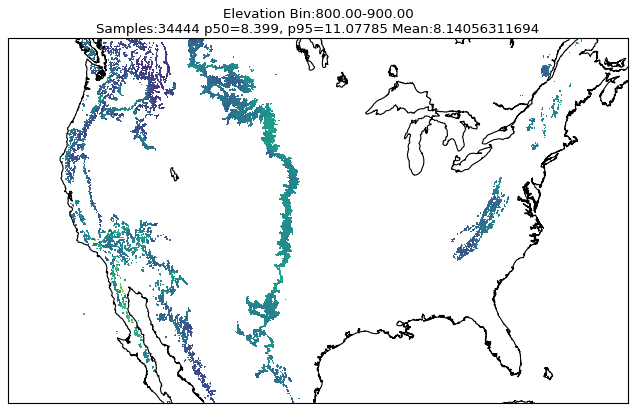

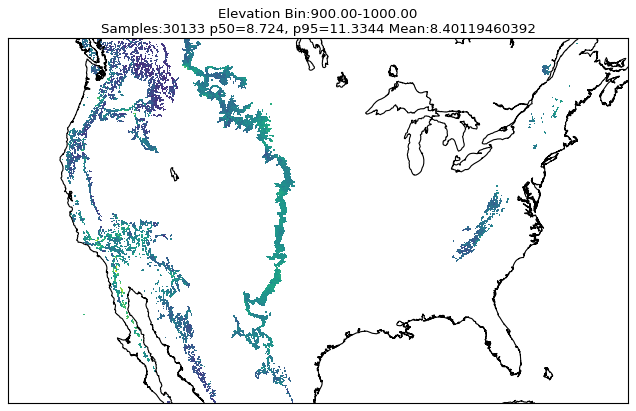

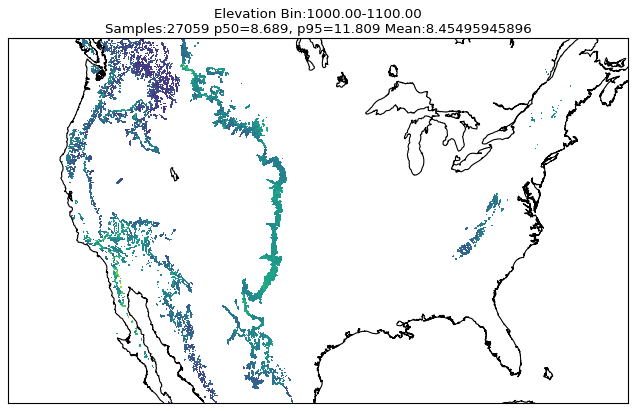

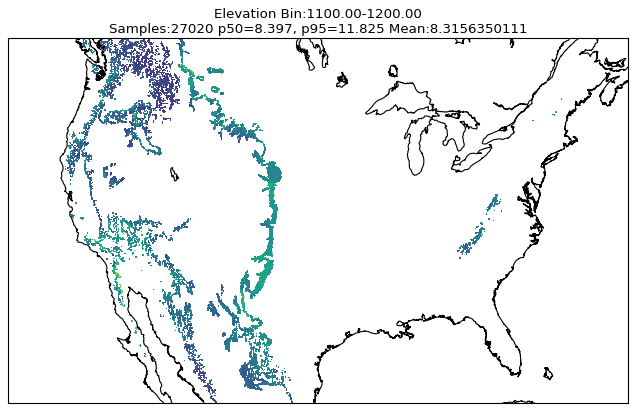

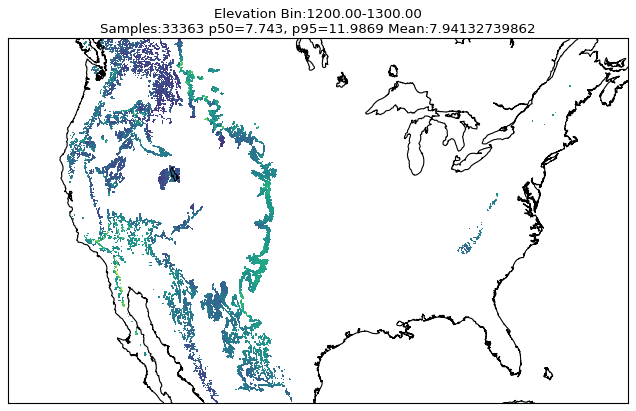

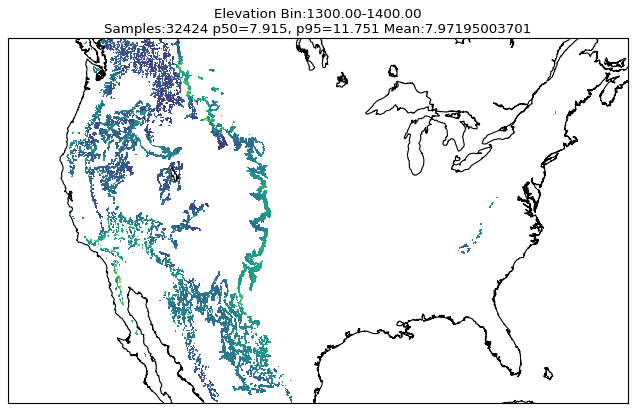

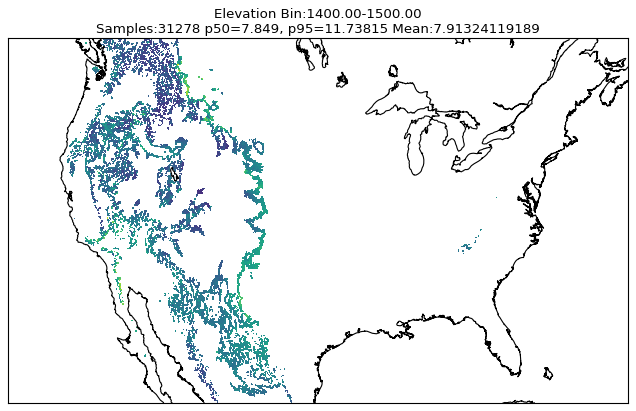

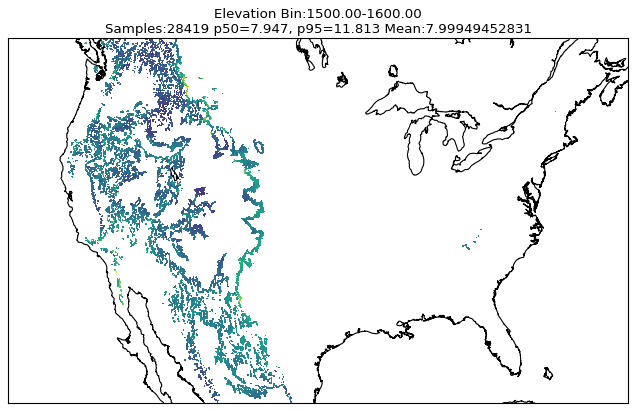

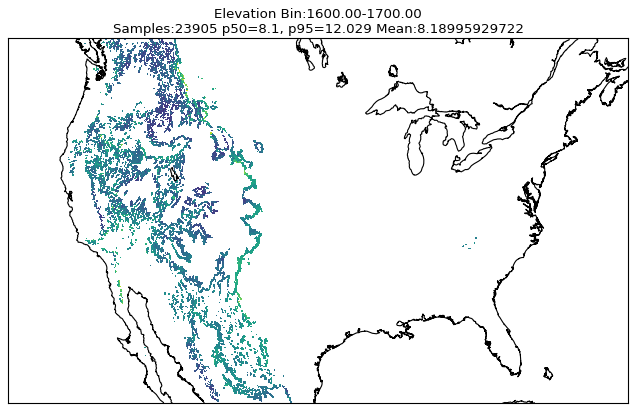

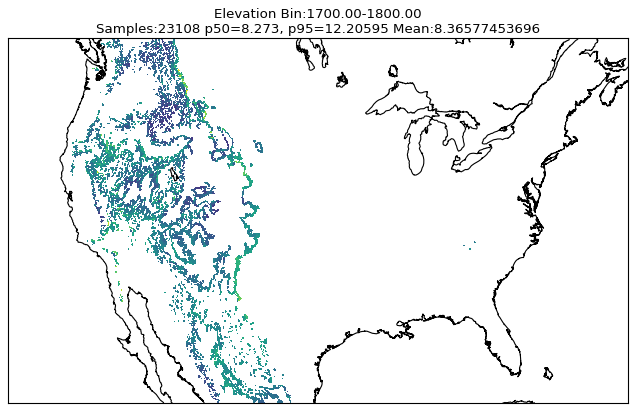

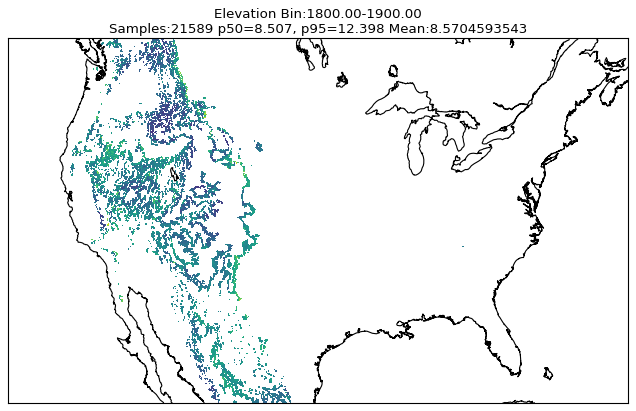

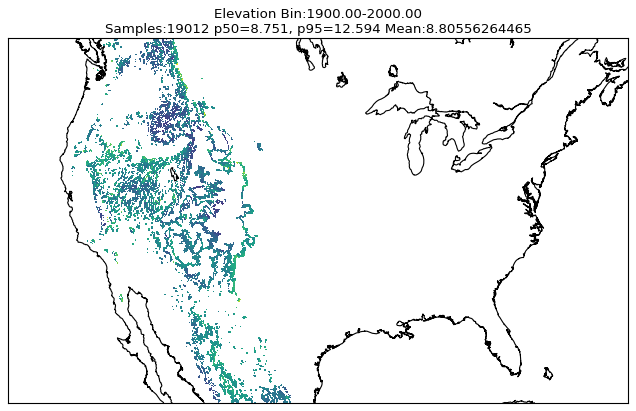

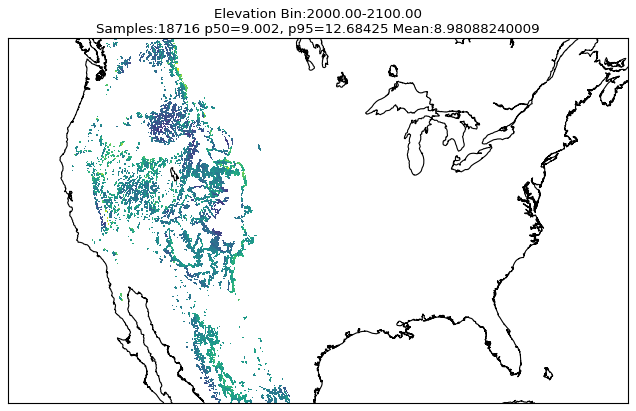

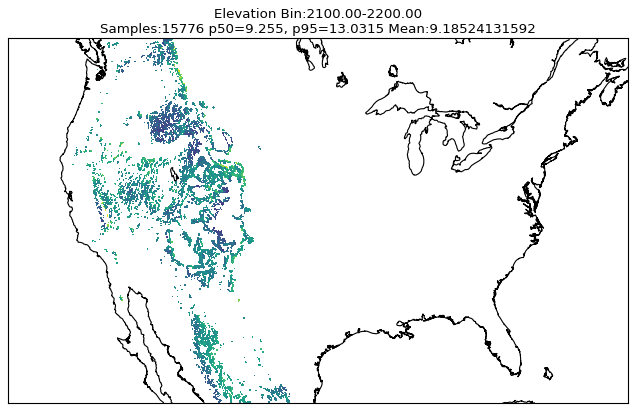

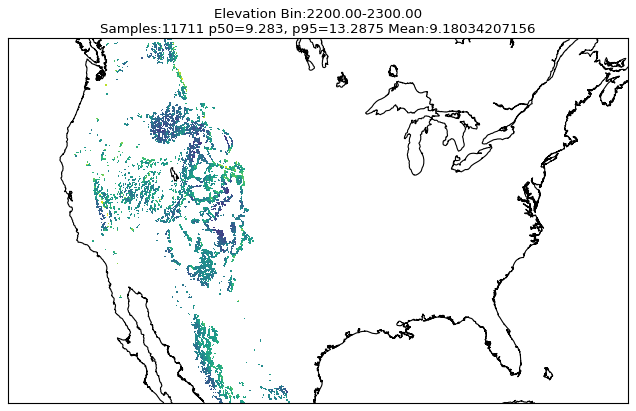

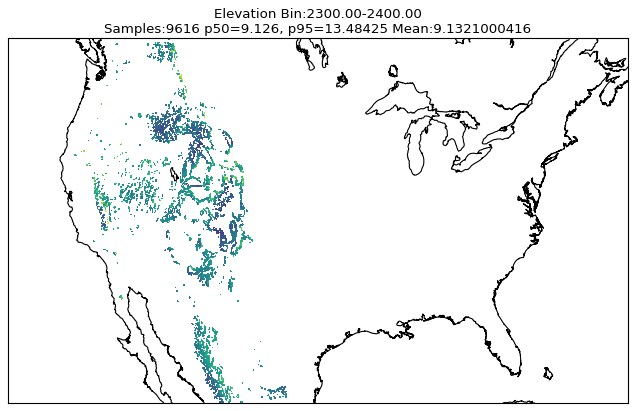

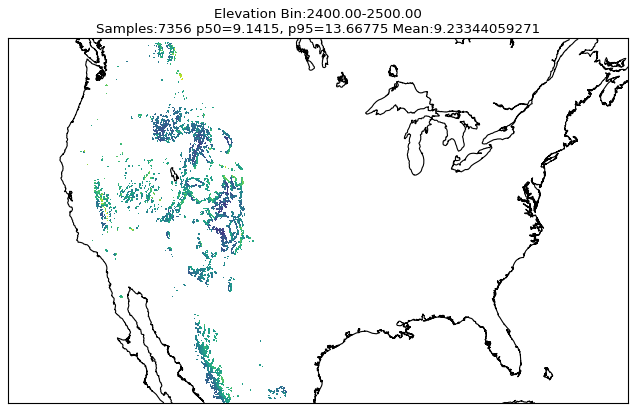

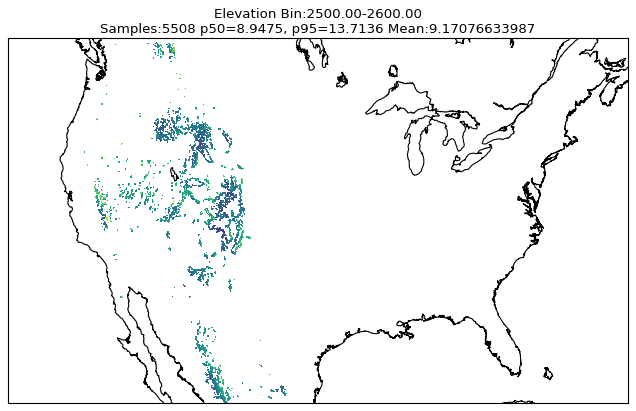

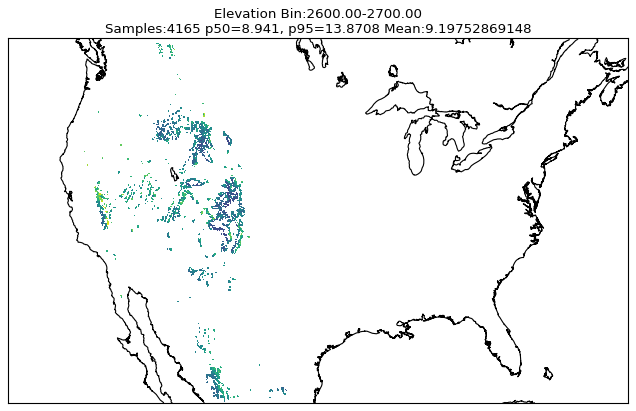

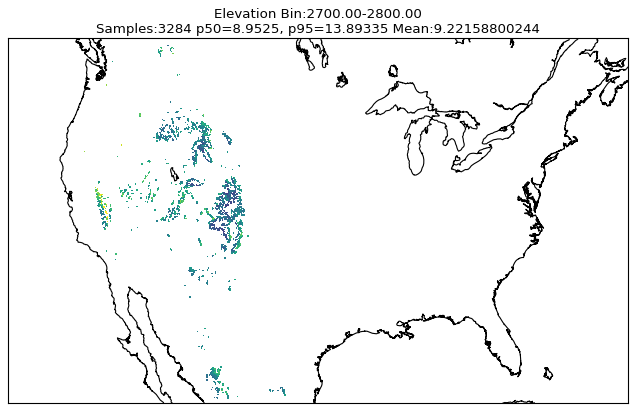

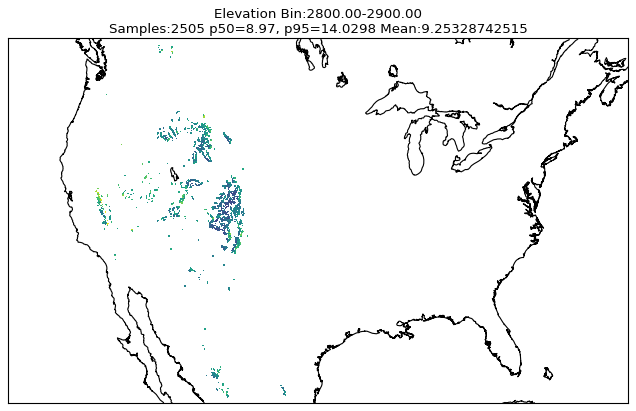

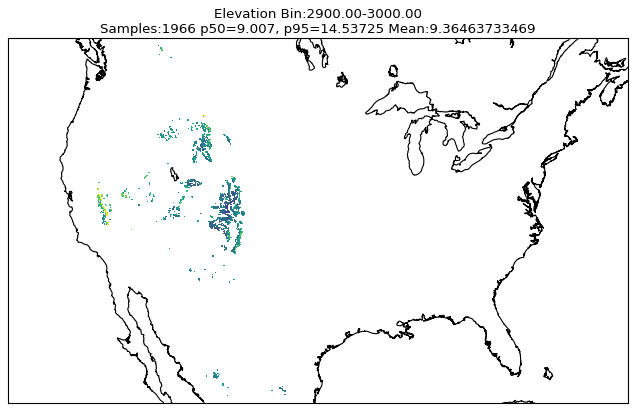

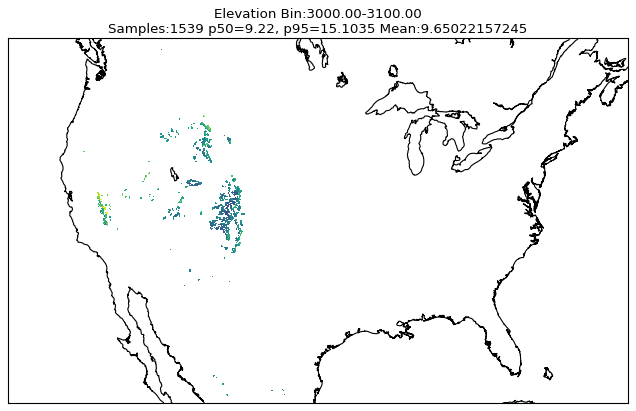

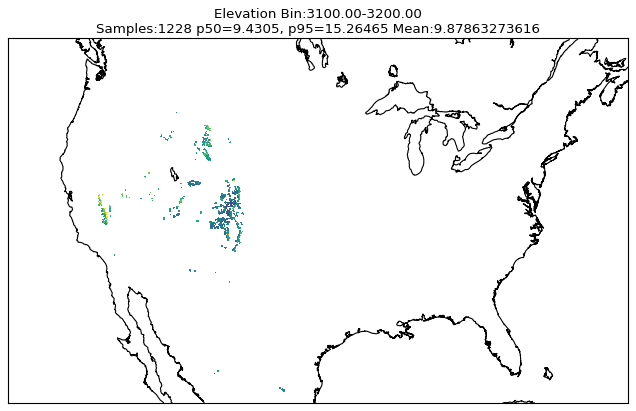

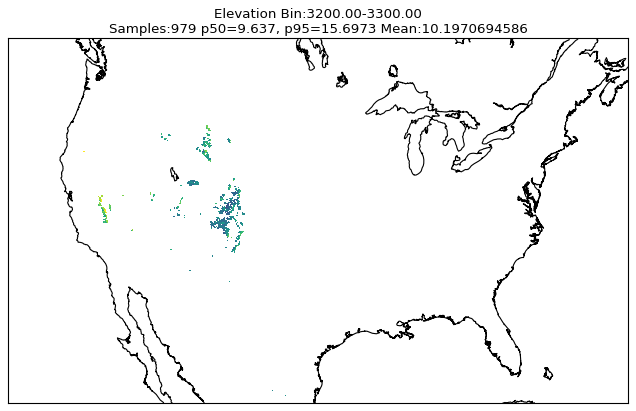

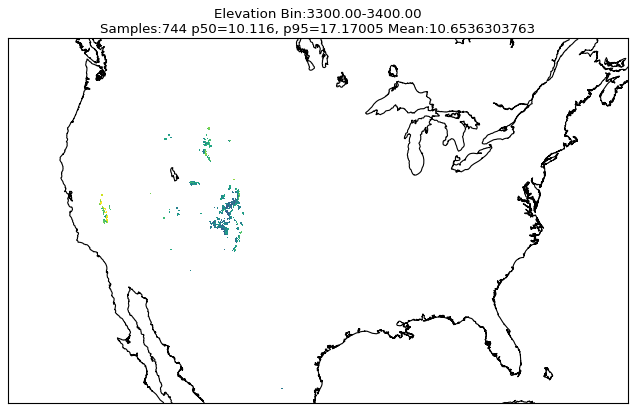

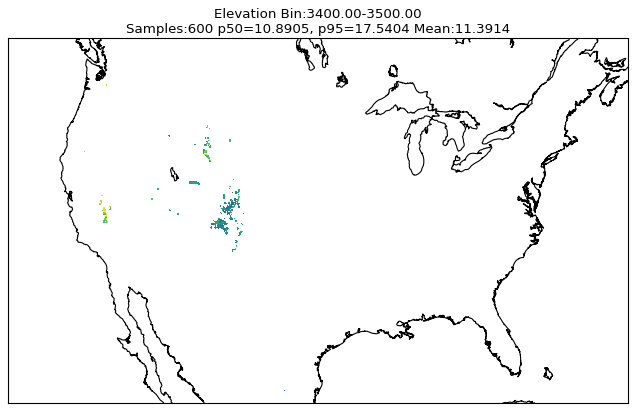

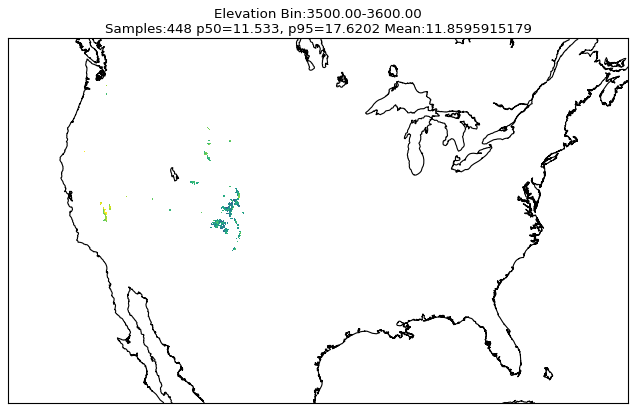

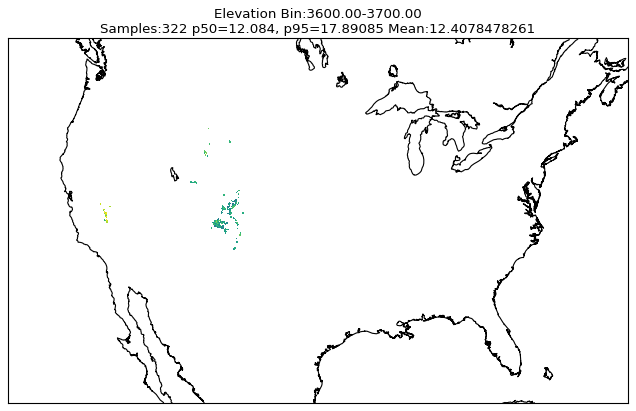

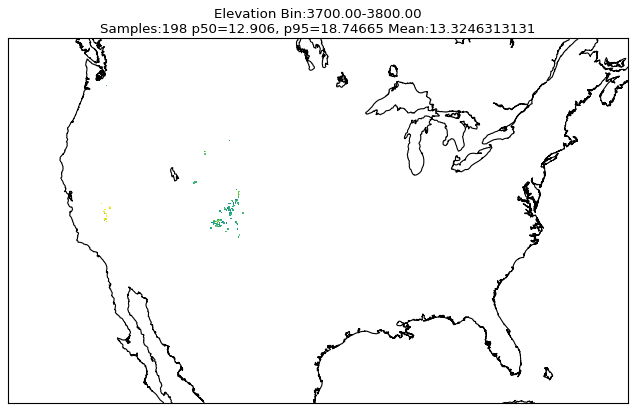

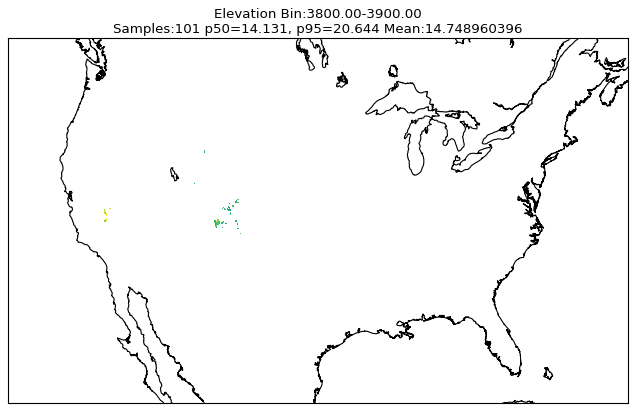

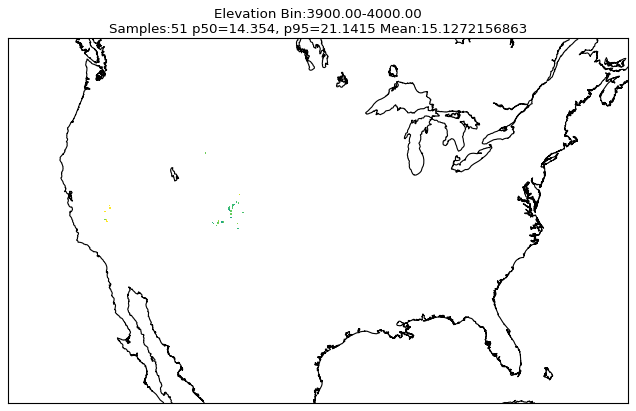

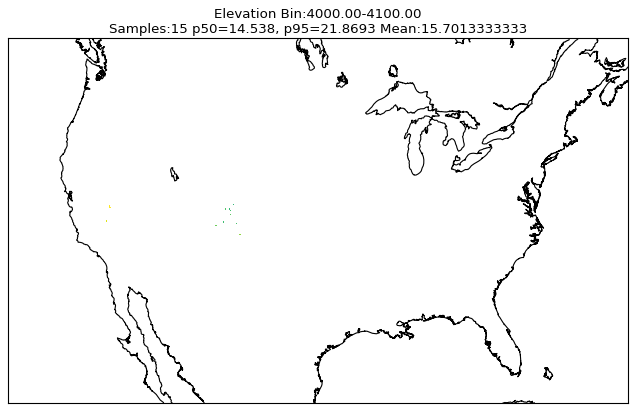

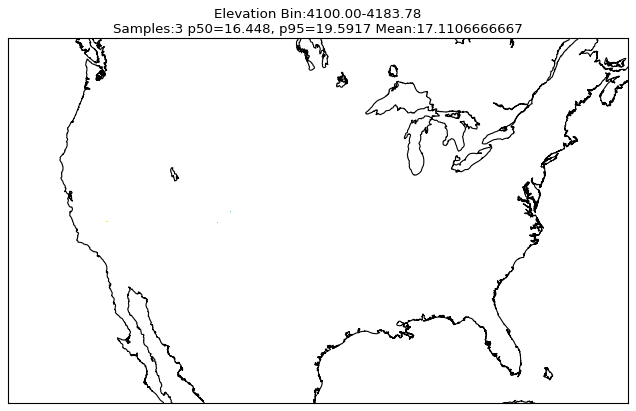

In [204]:
month = 6
day = 15
hour = 18

STAT = 'p95'

var = 'UVGRD:10 m'
variable = var.replace(':', '_').replace(' ', '_')

# open the file for the month
for month in range(1,13):
    DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/hourly30/%s/' % (variable)
    FILE = DIR + 'OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % \
                  (variable, month, day, hour)

    with h5py.File(FILE, 'r') as f:
        p95 = f[STAT].value

    # Loop through each elevation section
    for i in range(len(HGT_bins)-1):
        pixels_in_bin = np.logical_and(H['value'] > HGT_bins[i], H['value'] <= HGT_bins[i+1])

        p95_bin = p95
        p95_bin = np.ma.array(p95)
        p95_bin[pixels_in_bin == False] = np.ma.masked



        area_per = np.percentile(p95[pixels_in_bin], [50, 95])
        area_mean = np.mean(p95[pixels_in_bin])
        
        storage_p50[i, month-1] = area_per[0]
        storage_p95[i, month-1] = area_per[1]
        storage_mean[i, month-1] = np.mean(p95[pixels_in_bin])
        storage_samples[i, month-1] = np.sum(pixels_in_bin)

        if month == 1:
            plt.figure(i)
            m.drawcoastlines()
            m.pcolormesh(lon, lat, p95_bin,
                         cmap='viridis',
                         vmax=20, vmin=0,
                         latlon=True)
            plt.title('Elevation Bin:%.2f-%.2f\nSamples:%s p50=%s, p95=%s Mean:%s' % (HGT_bins[i], HGT_bins[i+1], np.sum(pixels_in_bin), area_per[0], area_per[1], np.mean(p95_bin)))
            plt.savefig('./figs/elev_bin_%02d' % (i))

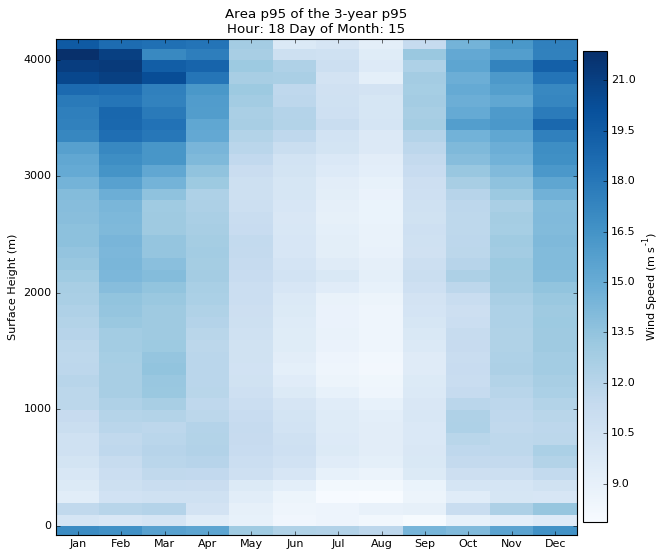

In [197]:
plt.title('Area p95 of the 3-year p95\nHour: %s Day of Month: %s' % (hour, day))
plt.pcolormesh(range(1,14), HGT_bins, storage_p95, cmap='Blues')
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label(r'Wind Speed (m s$\mathregular{^{-1}}$)')

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlim([1,13])
t = plt.xticks(np.arange(1.5,13,1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.savefig('./figs/HRRR_p95ofp95_h%02d_d%02d' % (hour, day))

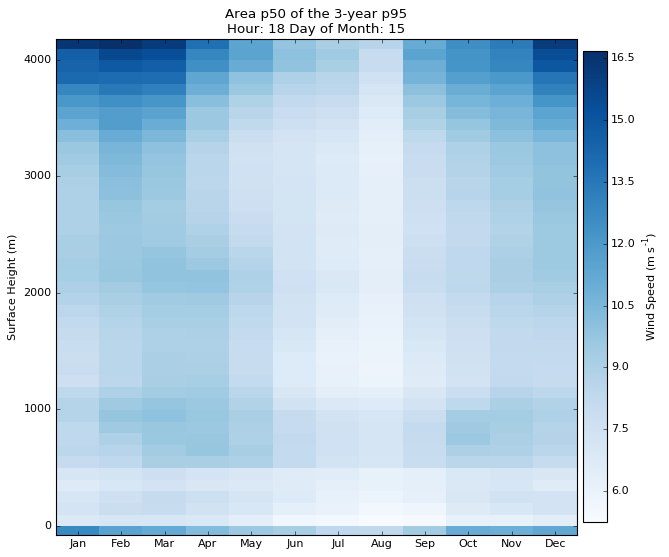

In [198]:
plt.title('Area p50 of the 3-year p95\nHour: %s Day of Month: %s' % (hour, day))
plt.pcolormesh(range(1,14), HGT_bins, storage_p50, cmap='Blues')
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label(r'Wind Speed (m s$\mathregular{^{-1}}$)')

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlim([1,13])
t = plt.xticks(np.arange(1.5,13,1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.savefig('./figs/HRRR_p50ofp95_h%02d_d%02d' % (hour, day))

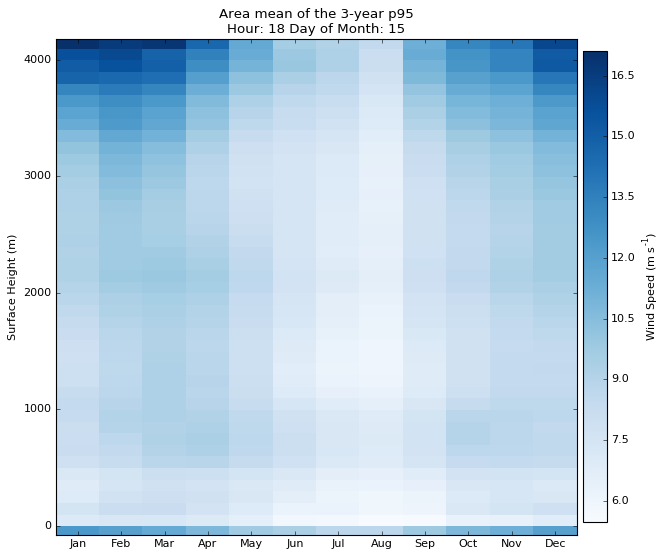

In [199]:
plt.title('Area mean of the 3-year p95\nHour: %s Day of Month: %s' % (hour, day))
plt.pcolormesh(range(1,14), HGT_bins, storage_mean, cmap='Blues')
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label(r'Wind Speed (m s$\mathregular{^{-1}}$)')

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlim([1,13])
t = plt.xticks(np.arange(1.5,13,1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.savefig('./figs/HRRR_meanofp95_h%02d_d%02d' % (hour, day))

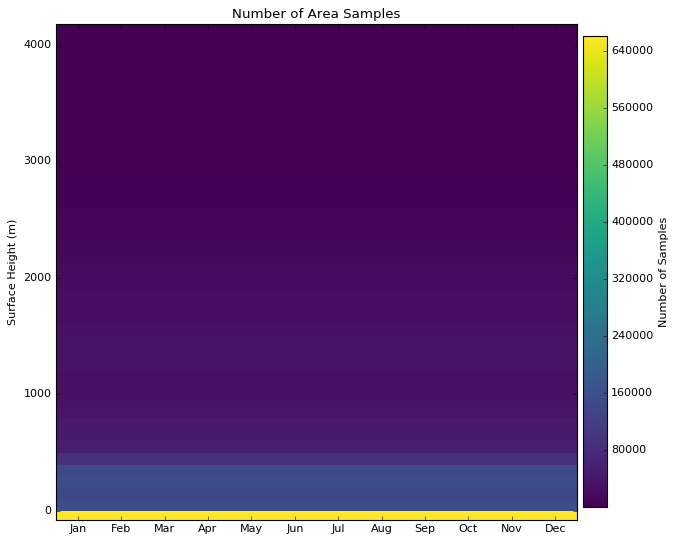

In [200]:
plt.title('Number of Area Samples')
plt.pcolormesh(range(1,14), HGT_bins, storage_samples, cmap='viridis')
cb = plt.colorbar(orientation='vertical', pad=0.01, shrink=.95)
cb.set_label('Number of Samples')

plt.ylim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Surface Height (m)')
plt.xlim([1,13])
t = plt.xticks(np.arange(1.5,13,1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.savefig('./figs/HRRR_samples_h%02d_d%02d' % (hour, day))

[  6.60600000e+05   1.51512000e+05   1.40490000e+05   1.52659000e+05
   1.46312000e+05   9.12240000e+04   5.66760000e+04   4.47920000e+04
   4.22890000e+04   3.44440000e+04   3.01330000e+04   2.70590000e+04
   2.70200000e+04   3.33630000e+04   3.24240000e+04   3.12780000e+04
   2.84190000e+04   2.39050000e+04   2.31080000e+04   2.15890000e+04
   1.90120000e+04   1.87160000e+04   1.57760000e+04   1.17110000e+04
   9.61600000e+03   7.35600000e+03   5.50800000e+03   4.16500000e+03
   3.28400000e+03   2.50500000e+03   1.96600000e+03   1.53900000e+03
   1.22800000e+03   9.79000000e+02   7.44000000e+02   6.00000000e+02
   4.48000000e+02   3.22000000e+02   1.98000000e+02   1.01000000e+02
   5.10000000e+01   1.50000000e+01   3.00000000e+00   0.00000000e+00]


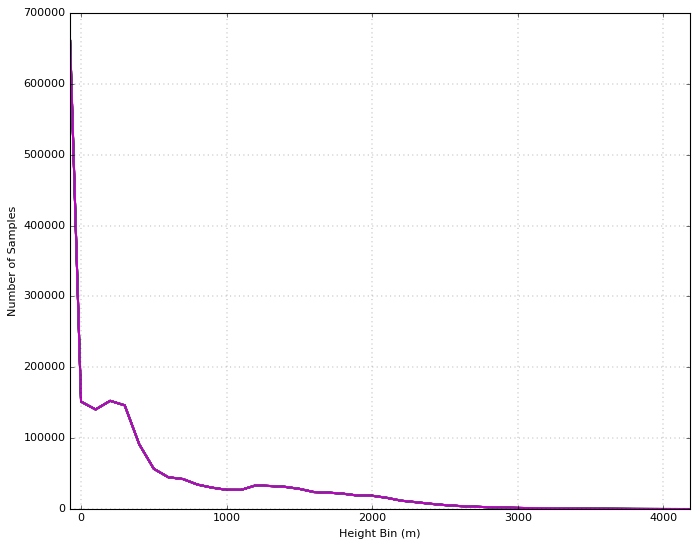

In [185]:
t = plt.plot(HGT_bins, storage_samples)
plt.xlim([HGT_bins[0], HGT_bins[-1]])
plt.ylabel('Number of Samples')
plt.xlabel('Height Bin (m)')
plt.grid()

print storage_samples[:,0]